# 1.import necessary libraries


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
dataset_dir = '/content/drive/MyDrive/AIO/image_retrieval_dataset.zip'
!unzip "{dataset_dir}" -d dataset_dir

Archive:  /content/drive/MyDrive/AIO/image_retrieval_dataset.zip
replace dataset_dir/images_mr/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
dataset_dir = '/content/dataset_dir/images_mr'

In [ ]:
image_filenames = os.listdir(dataset_dir)
print(image_filenames)

['1787.jpg', '1755.jpg', '9624.jpg', '1870.jpg', '8733.jpg', '7851.jpg', '5936.jpg', '6217.jpg', '8604.jpg', '7874.jpg', '3980.jpg', '7492.jpg', '1523.jpg', '8767.jpg', '8981.jpg', '7397.jpg', '4344.jpg', '3007.jpg', '5920.jpg', '9411.jpg', '6376.jpg', '2912.jpg', '4632.jpg', '9006.jpg', '5810.jpg', '4541.jpg', '1632.jpg', '1447.jpg', '1032.jpg', '3151.jpg', '7381.jpg', '6131.jpg', '4657.jpg', '7889.jpg', '1223.jpg', '4963.jpg', '84.jpg', '2756.jpg', '986.jpg', '5077.jpg', '1038.jpg', '7625.jpg', '5830.jpg', '938.jpg', '8837.jpg', '8675.jpg', '6968.jpg', '7854.jpg', '966.jpg', '8864.jpg', '7867.jpg', '4330.jpg', '319.jpg', '4402.jpg', '1186.jpg', '4747.jpg', '8788.jpg', '87.jpg', '8758.jpg', '9132.jpg', '3031.jpg', '5807.jpg', '5877.jpg', '4270.jpg', '4764.jpg', '5949.jpg', '9732.jpg', '5694.jpg', '7642.jpg', '6995.jpg', '7538.jpg', '4403.jpg', '7622.jpg', '8477.jpg', '3817.jpg', '7169.jpg', '9532.jpg', '6942.jpg', '4185.jpg', '7840.jpg', '7677.jpg', '1997.jpg', '910.jpg', '4353.jpg', 

# 2.Read images

In [ ]:
src_images = []

for filename in image_filenames:
  filepath = os.path.join(
      dataset_dir,
      filename
  )

  image = cv2.imread(filepath)
  image = cv2.cvtColor(
      image,
      cv2.COLOR_BGR2RGB
  )
  src_images.append(image)

# 3.Preprocess Image


## 3.1 Resize

In [ ]:
def image_resize(images, target_size = (64,64)):
  resized_image = cv2.resize(images, target_size)
  return resized_image

## 3.2 Normalize
(boost performence of system)

In [ ]:
def calculate_mean_std(images):
  mean = np.mean(images, axis=(0,1,2))
  std = np.std(images, axis = (0,1,2))
  return mean, std

In [ ]:
def image_normalize(images, mean,std):
  normalized_image = (images-mean) / std
  return normalized_image

## 3.3 Flatten
(flatten thành 1D để thuận tiện trong lúc áp hàm tính độ tương đồng)


In [ ]:
def image_flatten(images, is_batch = False):
  #for flatten a bunch of images
  if is_batch:
    flattened_image = images.reshape(images.shape[0], -1)
  # for flatten a single image
  else:
    flattened_image = images.reshape(-1)
  return flattened_image

## 3.4 Final Preprocess

In [ ]:
def database_preprocess(src_images):
  resized_images = [image_resize(image) for image in src_images]

  resized_images = np.array(resized_images)
  mean,std = calculate_mean_std(resized_images)
  normalized_images = image_normalize(resized_images, mean,std)

  flattened_images = image_flatten(normalized_images, is_batch = True)
  return flattened_images, mean, std

In [ ]:
def query_preprocess(image):
  resized_images = image_resize(image)
  normalized_images = image_normalize(resized_images, mean,std)
  flattened_images = image_flatten(normalized_images, is_batch = False)
  return flattened_images

In [ ]:
database, mean, std = database_preprocess(src_images)


In [ ]:
database.shape

(9908, 12288)

# 4.Define Similarity Metrics

In [ ]:
def mean_absolute_error(query_vector, src_vectors):
    abs_diff = np.abs(src_vectors - query_vector)
    mae = np.mean(abs_diff, axis=1)
    return mae

def mean_squared_error(query_vector, src_vectors):
    squared_diff = (src_vectors - query_vector) ** 2
    mse = np.mean(squared_diff, axis=1)
    return mse

def cosine_similarity(query_vector, src_vectors):
    query_norm = np.linalg.norm(query_vector)
    normalized_query = query_vector / query_norm
    src_norms = np.linalg.norm(src_vectors, axis=1)
    normalized_src = src_vectors / src_norms[:, np.newaxis]
    cosine_similarity = np.dot(normalized_src, normalized_query)
    return cosine_similarity

def correlation_coefficient(query_vector, src_vectors):
    return np.corrcoef(query_vector, src_vectors)[:-1, -1]

# 5.Ranking

In [ ]:
def ranking(preprocessed_query_image, preprocessed_src_images, top_k=10):
    scores = cosine_similarity(preprocessed_query_image, preprocessed_src_images)
    ranked_list = np.argsort(scores)[::-1][:top_k]
    scores = scores[ranked_list]
    return ranked_list, scores

# 6.Predict

Query Image


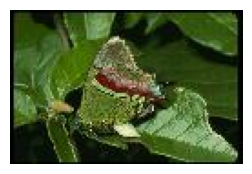

Top 10 results


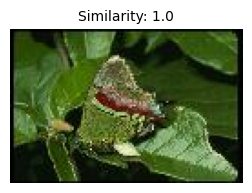

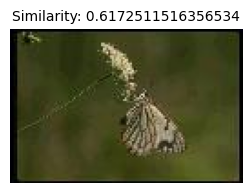

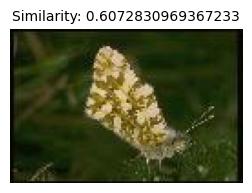

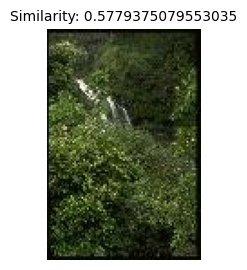

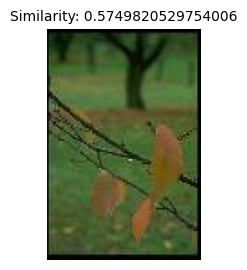

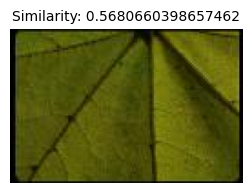

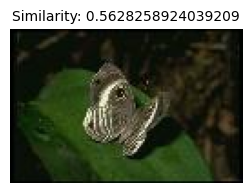

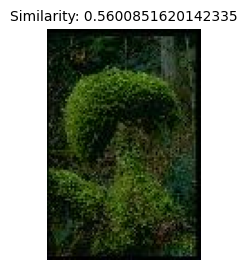

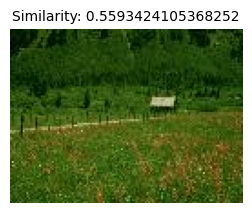

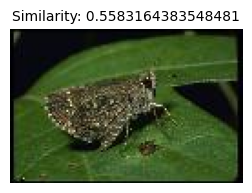

In [ ]:
query_image_paths = [
    '/content/dataset_dir/images_mr/1.jpg'
]

top_k = 10

for query_image_path in query_image_paths:
    query_image = cv2.imread(query_image_path, 1)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    preprocessed_query_image = query_preprocess(query_image)

    ranked_list, scores = ranking(preprocessed_query_image, database, top_k)

    print('Query Image')
    plt.figure(figsize=(3, 3))
    plt.imshow(query_image)
    plt.axis('off')
    plt.show()

    print(f'Top {top_k} results')
    for idx in range(len(ranked_list)):
        src_image_idx = ranked_list[idx]
        similarity_score = scores[idx]
        plt.figure(figsize=(3, 3))
        plt.imshow(src_images[src_image_idx])
        plt.title(f'Similarity: {similarity_score}', fontsize=10)
        plt.axis('off')
        plt.show()